# Rozpoznawanie kart do gry przy użyciu sieci neuronowych

---
Dataset: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

This is a very high quality dataset of playing card images. All images are 224 X 224 X 3 in jpg format. All images in the dataset have been cropped so that only the image of a single card is present and the card occupies well over 50% of the pixels in the image. There are 7624 training images, 265 test images and 265 validation images. The train, test and validation directories are partitioned into 53 sub directories , one for each of the 53 types of cards. The dataset also includes a csv file which can be used to load the datasets

## Import

In [ ]:
import os
import uuid
import shutil
import random
import pickle
import kagglehub
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Rescaling, Activation, SpatialDropout2D, Input, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ds_path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")
print("Path to dataset files:", ds_path)

100%|██████████| 385M/385M [00:03<00:00, 117MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2


## Przygotowanie folderów

### Konfiguracja

In [ ]:
# GDrive
gdrive_path = '/content/drive/MyDrive'

# Source directory path
source_dir = ds_path

# New model name (output)
model_name = 'Natrenowany'

# Validation dataset directory
val_dir = 'test'

# Train dataset directory
train_dir = 'train'

# Validation dataset for evaluate
val_e_dir = 'valid'


# ======================================
batch_size=32
color_mode='rgb'
image_size=(224, 224)
train_path = f'{source_dir}/{train_dir}'
val_path = f'{source_dir}/{val_dir}'
val_evaluate_path = f'{source_dir}/{val_e_dir}'

# Work dir
class_names_path = f'{gdrive_path}/Cards/class_names.json'
model_dir = f'{gdrive_path}/Cards/{model_name}'
gdrive_path_work = f'{gdrive_path}/Cards'
logs_fit_path = f'{gdrive_path_work}/logs/fit/{model_name}'
history_path = f'{gdrive_path_work}/history'
history_model_path = f'{gdrive_path_work}/history/{model_name}'
!mkdir -p {gdrive_path_work}
!mkdir -p {logs_fit_path}
!mkdir -p {history_path}

### Połączenie zbiorów

In [ ]:
merged_dir = 'merged'
os.makedirs(merged_dir, exist_ok=True)

# Funkcja do kopiowania plików z jednego folderu do drugiego
def merge_folders(source_dir, target_dir):
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):  # Sprawdzamy, czy to podfolder (klasa)
            target_class_dir = os.path.join(target_dir, class_name)
            os.makedirs(target_class_dir, exist_ok=True)
            for file_name in os.listdir(class_path):
                source_file = os.path.join(class_path, file_name)

                # Generowanie unikalnej nazwy, jeśli plik już istnieje
                base_name, ext = os.path.splitext(file_name)
                target_file = os.path.join(target_class_dir, file_name)
                while os.path.exists(target_file):
                    unique_id = uuid.uuid4().hex[:8]  # Generuje unikalny identyfikator (8 znaków)
                    file_name = f"{base_name}_{unique_id}{ext}"
                    target_file = os.path.join(target_class_dir, file_name)

                shutil.copy2(source_file, target_file)

# Łączenie folderów treningowego, testowego i walidacyjnego
merge_folders(train_path, merged_dir)
merge_folders(val_path, merged_dir)
merge_folders(val_evaluate_path, merged_dir)

In [ ]:
output_dirs = {
    "train": "split_train",
    "test": "split_test",
    "valid": "split_valid"
}

# Tworzenie folderów wyjściowych
for folder in output_dirs.values():
    os.makedirs(folder, exist_ok=True)

# Funkcja do podziału plików
def split_data_fixed(source_dir, output_dirs, test_count=10, valid_count=10):
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):  # Sprawdzamy, czy to podfolder (klasa)
            files = os.listdir(class_path)
            random.shuffle(files)  # Tasowanie plików w celu losowego podziału

            # Przydzielanie zdjęć do zbiorów
            test_files = files[:test_count]
            valid_files = files[test_count:test_count + valid_count]
            train_files = files[test_count + valid_count:]

            # Funkcja pomocnicza do kopiowania plików
            def copy_files(file_list, target_dir):
                target_class_dir = os.path.join(target_dir, class_name)
                os.makedirs(target_class_dir, exist_ok=True)
                for file_name in file_list:
                    source_file = os.path.join(class_path, file_name)
                    target_file = os.path.join(target_class_dir, file_name)
                    shutil.copy2(source_file, target_file)

            # Kopiowanie plików do odpowiednich folderów
            copy_files(train_files, output_dirs["train"])
            copy_files(test_files, output_dirs["test"])
            copy_files(valid_files, output_dirs["valid"])

# Podział danych
split_data_fixed(merged_dir, output_dirs)

## Utworzenie obiektu tensorflow-dataset

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    output_dirs['train'],
    image_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size)

Found 7094 files belonging to 53 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    output_dirs['test'],
    image_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size)

Found 530 files belonging to 53 classes.


In [ ]:
val_evaluate_ds = tf.keras.utils.image_dataset_from_directory(
    output_dirs['valid'],
    image_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size,
    shuffle=False)

Found 530 files belonging to 53 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

# Save to file as json strinify
with open(class_names_path, 'w') as file:
  file.write(str(class_names))

['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']


## Modele

### Model bazowy

In [ ]:
model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Rescaling(1./255))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((8, 8)))

model.add(Flatten())
model.add(Dense(53, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 53)                  │       2,472,821 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,474,613 (9.44 MB)

 Trainable params: 2,474,613 (9.44 MB)

 Non-trainable params: 0 (0.00 B)

### Model pośredni

In [ ]:
# Model pośredni
model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Rescaling(1./255))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(53, activation='softmax'))


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 256)       │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 10, 10, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 53)                  │           6,837 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320,181 (5.04 MB)

 Trainable params: 1,320,181 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

### Model optymalny

In [ ]:
model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Rescaling(1./255))


model.add(Conv2D(32, (3, 3), kernel_initializer='he_normal', use_bias=False, padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), kernel_initializer='he_normal', use_bias=False, padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D((4, 4)))
model.add(SpatialDropout2D(0.3))


model.add(Conv2D(64, (3, 3), kernel_initializer='he_normal', use_bias=False, padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), kernel_initializer='he_normal', use_bias=False, padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.3))


model.add(Conv2D(128, (3, 3), kernel_initializer='he_normal', use_bias=False, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Conv2D(128, (3, 3), kernel_initializer='he_normal', use_bias=False, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Conv2D(128, (3, 3), kernel_initializer='he_normal', use_bias=False, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.3))


model.add(Conv2D(256, (3, 3), kernel_initializer='he_normal', use_bias=False, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Conv2D(256, (3, 3), kernel_initializer='he_normal', use_bias=False, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Conv2D(256, (3, 3), kernel_initializer='he_normal', use_bias=False, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Conv2D(256, (3, 3), kernel_initializer='he_normal', use_bias=False, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.3))

model.add(Flatten())

model.add(Dense(256, kernel_initializer='he_normal', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.2))

model.add(Dense(128, kernel_initializer='he_normal', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.2))

model.add(Dense(53, activation='softmax'))


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 224, 224, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_69 (Activation)           │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 224, 224, 32)        │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_70 (Activation)           │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_21                 │ (None, 56, 56, 32)          │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (None, 56, 56, 64)          │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_71 (Activation)           │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_70 (Conv2D)                   │ (None, 56, 56, 64)          │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_72 (Activation)           │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_22                 │ (None, 28, 28, 64)          │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (None, 28, 28, 128)         │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_73 (Activation)           │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ (None, 28, 28, 128)         │         147,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_74 (Activation)           │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,756,437 (21.96 MB)

 Trainable params: 5,752,853 (21.95 MB)

 Non-trainable params: 3,584 (14.00 KB)

### Model optymalny+

In [ ]:
model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Rescaling(1./255))

# Block 1
model.add(Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.4))

# Block 2
model.add(Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.4))

# Block 3
model.add(Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.4))

# Classifier
model.add(GlobalAveragePooling2D())
model.add(Dense(2048, kernel_initializer='he_normal', kernel_regularizer=l2(0.001), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.3))
model.add(Dense(512, kernel_initializer='he_normal', kernel_regularizer=l2(0.001), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.3))
model.add(Dense(53, activation='softmax'))


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_17 (Rescaling)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_176 (Conv2D)                  │ (None, 224, 224, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_150              │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_198 (Activation)          │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_177 (Conv2D)                  │ (None, 224, 224, 32)        │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_151              │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_199 (Activation)          │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_68 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_60                 │ (None, 112, 112, 32)        │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_178 (Conv2D)                  │ (None, 112, 112, 64)        │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_152              │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_200 (Activation)          │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_179 (Conv2D)                  │ (None, 112, 112, 64)        │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_153              │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_201 (Activation)          │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_69 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_61                 │ (None, 56, 56, 64)          │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_180 (Conv2D)                  │ (None, 56, 56, 128)         │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,636,501 (6.24 MB)

 Trainable params: 1,630,485 (6.22 MB)

 Non-trainable params: 6,016 (23.50 KB)

In [ ]:
# Epoch 1/100
# 239/239 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.2175 - loss: 3.9658 - val_accuracy: 0.6000 - val_loss: 1.6073
# Epoch 2/100
# 239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.6178 - loss: 1.4986 - val_accuracy: 0.6453 - val_loss: 1.6843
# Epoch 3/100
# 239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.7805 - loss: 0.9072 - val_accuracy: 0.6453 - val_loss: 1.6860
# Epoch 4/100
# 239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8663 - loss: 0.5344 - val_accuracy: 0.6717 - val_loss: 2.0093
# Epoch 5/100
# 239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9197 - loss: 0.3514 - val_accuracy: 0.6642 - val_loss: 2.1669
# Epoch 6/100
# 239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9433 - loss: 0.2531 - val_accuracy: 0.6755 - val_loss: 2.2557
# Epoch 6: early stopping
# Restoring model weights from the end of the best epoch: 1.

### Model natrenowany

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

# Parametry
input_shape = (224, 224, 3)
num_classes = 53  # Liczba klas w Twoim projekcie (dla pełnej talii kart)

# Wczytanie wstępnie wytrenowanego modelu MobileNetV2
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Zamrożenie warstw bazy (nie będą trenowane)
base_model.trainable = False

# Stworzenie modelu
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Średnia globalna z cech
    Dense(128, activation='relu'),  # Dodanie w pełni połączonej warstwy
    Dropout(0.5),  # Regularizacja Dropout
    Dense(num_classes, activation='softmax')  # Warstwa wyjściowa
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 53)                  │           6,837 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,428,789 (9.27 MB)

 Trainable params: 170,805 (667.21 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Train

### Train | Bazowy

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logs_fit_path,
    histogram_freq=1)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)

#reduce_lr = ReduceLROnPlateau(monitor='val_loss',
#                              factor=0.2,
#                              verbose=1)

#history = model.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=50,
#    callbacks=[tensorboard_callback, early_stop, reduce_lr])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[tensorboard_callback, early_stop])


with open(history_model_path, 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

model.save(model_dir + '.keras')

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.2320 - loss: 3.4329 - val_accuracy: 0.4906 - val_loss: 1.9861
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.6476 - loss: 1.3987 - val_accuracy: 0.5358 - val_loss: 1.8554
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7935 - loss: 0.8179 - val_accuracy: 0.5755 - val_loss: 1.8925
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8847 - loss: 0.4688 - val_accuracy: 0.5868 - val_loss: 2.3201
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9284 - loss: 0.3213 - val_accuracy: 0.5962 - val_loss: 2.4176
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.9564 - loss: 0.2082 - val_accuracy: 0.5755 - val_loss: 2.5716
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9697 - loss: 0.1579 - val_accuracy: 0.5849 - val_loss: 2.8101
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


### Train | Pośredni

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logs_fit_path,
    histogram_freq=1)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
      factor=0.2,
      verbose=1)

history = model.fit(
   train_ds,
   validation_data=val_ds,
   epochs=50,
   callbacks=[tensorboard_callback, early_stop, reduce_lr])


with open(history_model_path, 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

model.save(model_dir + '.keras')

Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 67s 239ms/step - accuracy: 0.0591 - loss: 3.7824 - val_accuracy: 0.3151 - val_loss: 2.4882 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 50s 150ms/step - accuracy: 0.3994 - loss: 2.1552 - val_accuracy: 0.5491 - val_loss: 1.6888 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - accuracy: 0.5849 - loss: 1.5444 - val_accuracy: 0.6094 - val_loss: 1.4700 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.6717 - loss: 1.1865 - val_accuracy: 0.6849 - val_loss: 1.2790 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 42s 152ms/step - accuracy: 0.7372 - loss: 0.9126 - val_accuracy: 0.6604 - val_loss: 1.3887 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - accuracy: 0.7861 - loss: 0.7496 - val_accuracy: 0.6792 - val_loss: 1.3404 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.8

### Train | optymalny

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logs_fit_path,
    histogram_freq=1)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
      factor=0.2,
      verbose=1)

history = model.fit(
   train_ds,
   validation_data=val_ds,
   epochs=100,
   callbacks=[tensorboard_callback, early_stop, reduce_lr])


with open(history_model_path, 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

model.save(model_dir + '.keras')

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 176ms/step - accuracy: 0.0245 - loss: 4.3058 - val_accuracy: 0.0774 - val_loss: 3.8428 - learning_rate: 0.0010
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 50s 97ms/step - accuracy: 0.1808 - loss: 3.0412 - val_accuracy: 0.3642 - val_loss: 2.2357 - learning_rate: 0.0010
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.3541 - loss: 2.2254 - val_accuracy: 0.4755 - val_loss: 1.8284 - learning_rate: 0.0010
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.4876 - loss: 1.8594 - val_accuracy: 0.5453 - val_loss: 1.5693 - learning_rate: 0.0010
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.5621 - loss: 1.5853 - val_accuracy: 0.6396 - val_loss: 1.3040 - learning_rate: 0.0010
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 42s 98ms/step - accuracy: 0.6314 - loss: 1.3555 - val_accuracy: 0.6849 - val_loss: 1.1345 - learning_rate: 0.0010
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.

### Train | Optymalny+

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logs_fit_path,
    histogram_freq=1)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.2,
    verbose=1)

history = model.fit(
   train_ds,
   validation_data=val_ds,
   epochs=100,
   callbacks=[tensorboard_callback, early_stop, reduce_lr])


with open(history_model_path, 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

model.save(model_dir + '.keras')

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 54s 187ms/step - accuracy: 0.0371 - loss: 9.2993 - val_accuracy: 0.0528 - val_loss: 7.8269 - learning_rate: 0.0010
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 64s 139ms/step - accuracy: 0.0575 - loss: 7.2133 - val_accuracy: 0.0736 - val_loss: 5.8393 - learning_rate: 0.0010
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 31s 141ms/step - accuracy: 0.0671 - loss: 5.7742 - val_accuracy: 0.0792 - val_loss: 4.7724 - learning_rate: 0.0010
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - accuracy: 0.0756 - loss: 4.8080 - val_accuracy: 0.0434 - val_loss: 4.9427 - learning_rate: 0.0010
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - accuracy: 0.0759 - loss: 4.2401 - val_accuracy: 0.0774 - val_loss: 3.9228 - learning_rate: 0.0010
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - accuracy: 0.0805 - loss: 3.8883 - val_accuracy: 0.0981 - val_loss: 3.5779 - learning_rate: 0.0010
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - accura

KeyboardInterrupt: 

### Train | Natrenowany

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logs_fit_path,
    histogram_freq=1)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.2,
    verbose=1)

history = model.fit(
   train_ds,
   validation_data=val_ds,
   epochs=100,
   callbacks=[tensorboard_callback, early_stop, reduce_lr])


with open(history_model_path, 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

model.save(model_dir + '.keras')

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 104ms/step - accuracy: 0.0539 - loss: 3.9300 - val_accuracy: 0.1170 - val_loss: 3.2847 - learning_rate: 0.0010
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.1082 - loss: 3.3159 - val_accuracy: 0.1698 - val_loss: 2.9341 - learning_rate: 0.0010
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.1472 - loss: 3.0487 - val_accuracy: 0.2396 - val_loss: 2.7728 - learning_rate: 0.0010
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.1684 - loss: 2.9157 - val_accuracy: 0.2698 - val_loss: 2.6755 - learning_rate: 0.0010
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.2021 - loss: 2.7876 - val_accuracy: 0.2660 - val_loss: 2.5854 - learning_rate: 0.0010
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.2243 - loss: 2.7015 - val_accuracy: 0.2906 - val_loss: 2.5286 - learning_rate: 0.0010
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.2

## Model evaluate

### Bazowy

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5740 - loss: 1.9623
Test Loss: 1.8660337924957275
Test Accuracy: 0.5547170042991638
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
                   precision    recall  f1-score   support

     ace of clubs       0.67      0.80      0.73        10
  ace of diamonds       1.00      0.50      0.67        10
    ace of hearts       0.69      0.90      0.78        10
    ace of spades       0.78      0.70      0.74        10
   eight of clubs       0.33      0.40      0.36        10
eight of diamonds       0.75      0.30      0.43        10
  eight of hearts       0.28      0.50      0.36        10
  eight of spades       0.75      0.60      0.67        10
    five of clubs       1.00      0.60      0.75        10
 five of diamonds       0.86      0.60      0.71        10
   five of hearts       0.53      0.90      0.67        10
   five of spades       0.71      0.50      0.59        10
    four of clubs       0.50      0.80      0.62      

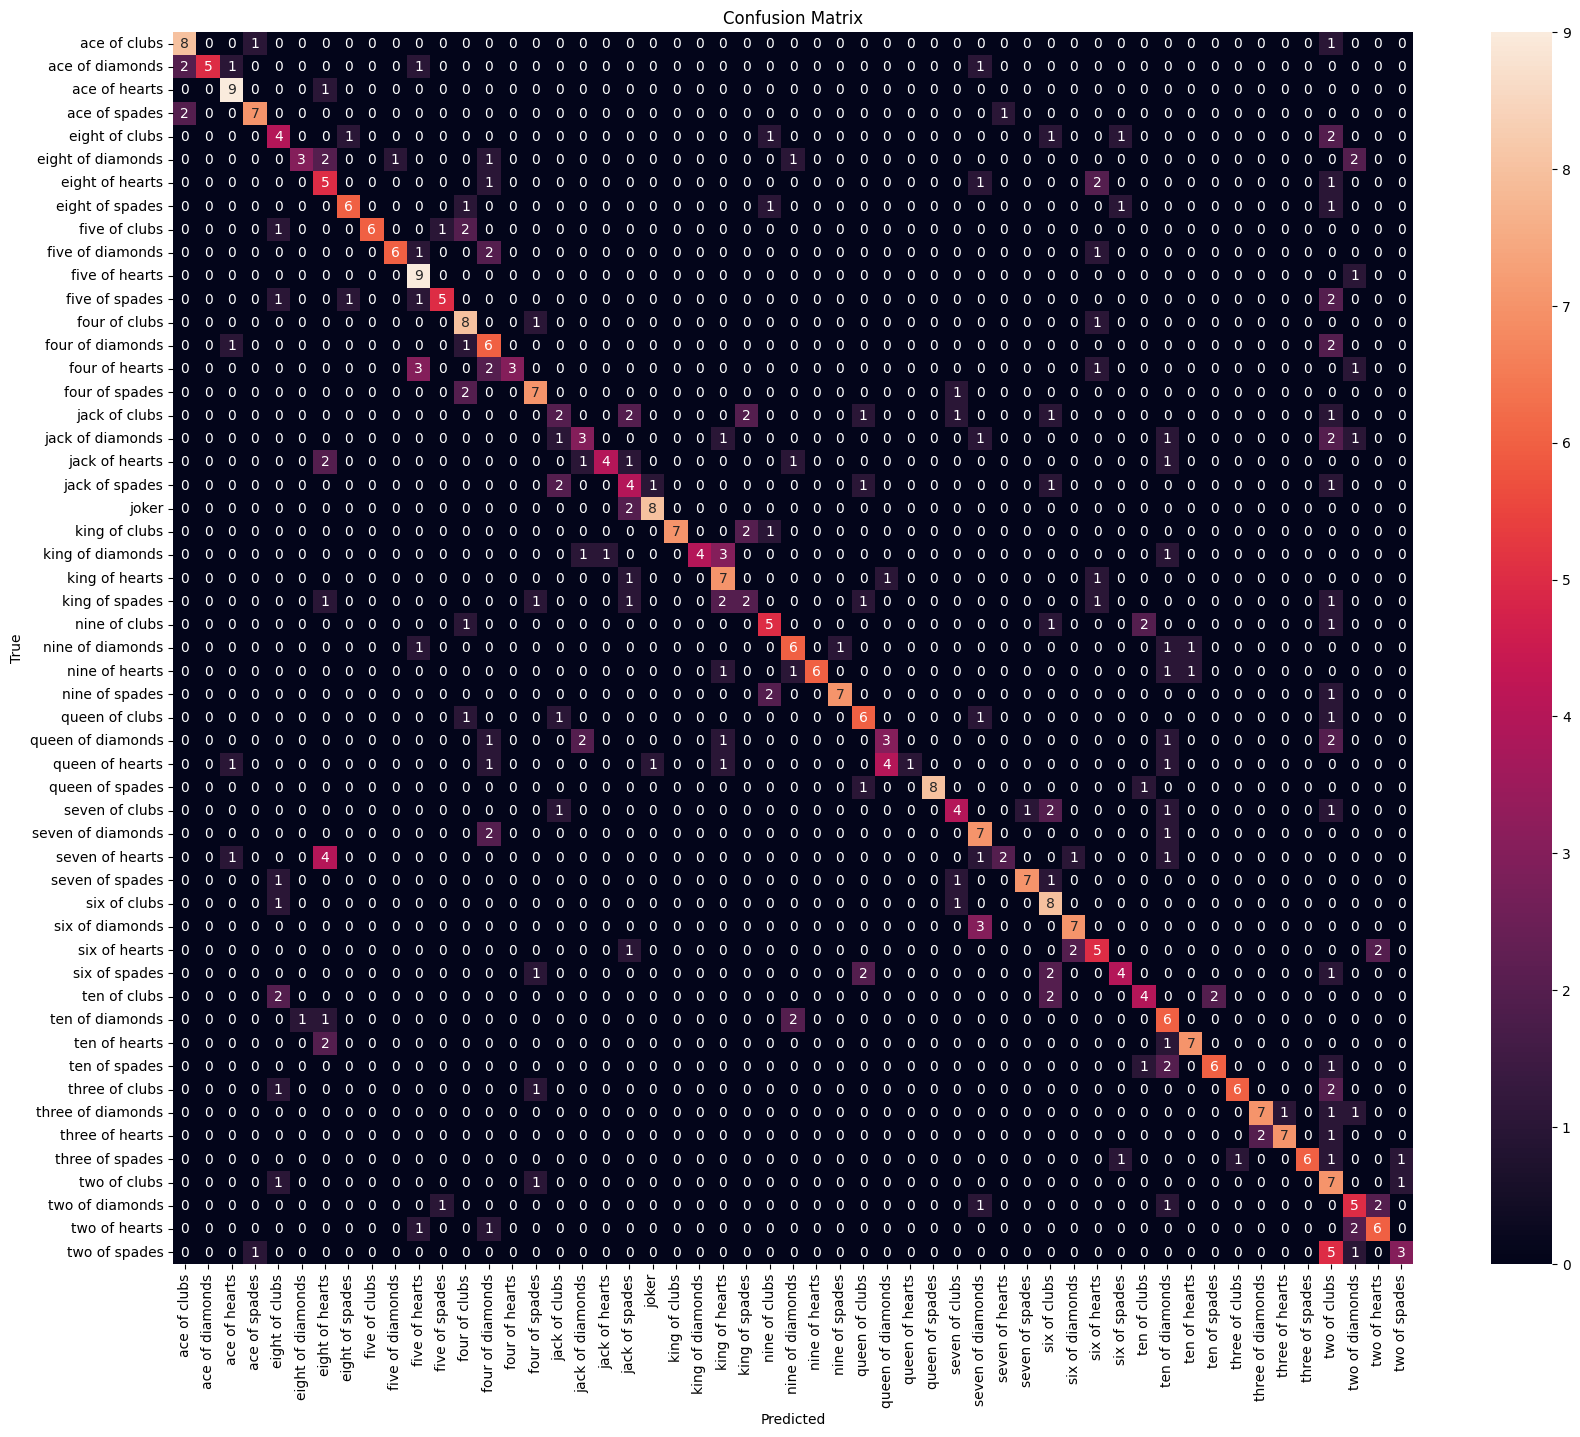

In [ ]:
# Ewaluacja modelu
test_loss, test_accuracy = model.evaluate(val_evaluate_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predykcja
y_true = np.concatenate([y for x, y in val_evaluate_ds], axis=0)  # Prawdziwe etykiety
y_pred = model.predict(val_evaluate_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # Przypisanie klas


# class_names = test_ds.class_names
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Macierz konfuzji
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Pośredni

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6577 - loss: 1.3453
Test Loss: 1.3204302787780762
Test Accuracy: 0.6603773832321167
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
                   precision    recall  f1-score   support

     ace of clubs       0.89      0.80      0.84        10
  ace of diamonds       0.86      0.60      0.71        10
    ace of hearts       0.82      0.90      0.86        10
    ace of spades       0.54      0.70      0.61        10
   eight of clubs       0.67      0.60      0.63        10
eight of diamonds       0.57      0.40      0.47        10
  eight of hearts       0.47      0.80      0.59        10
  eight of spades       0.80      0.40      0.53        10
    five of clubs       0.88      0.70      0.78        10
 five of diamonds       0.80      0.80      0.80        10
   five of hearts       0.62      0.80      0.70        10
   five of spades       0.83      0.50      0.62        10
    four of clubs       0.64      0.90      0.75      

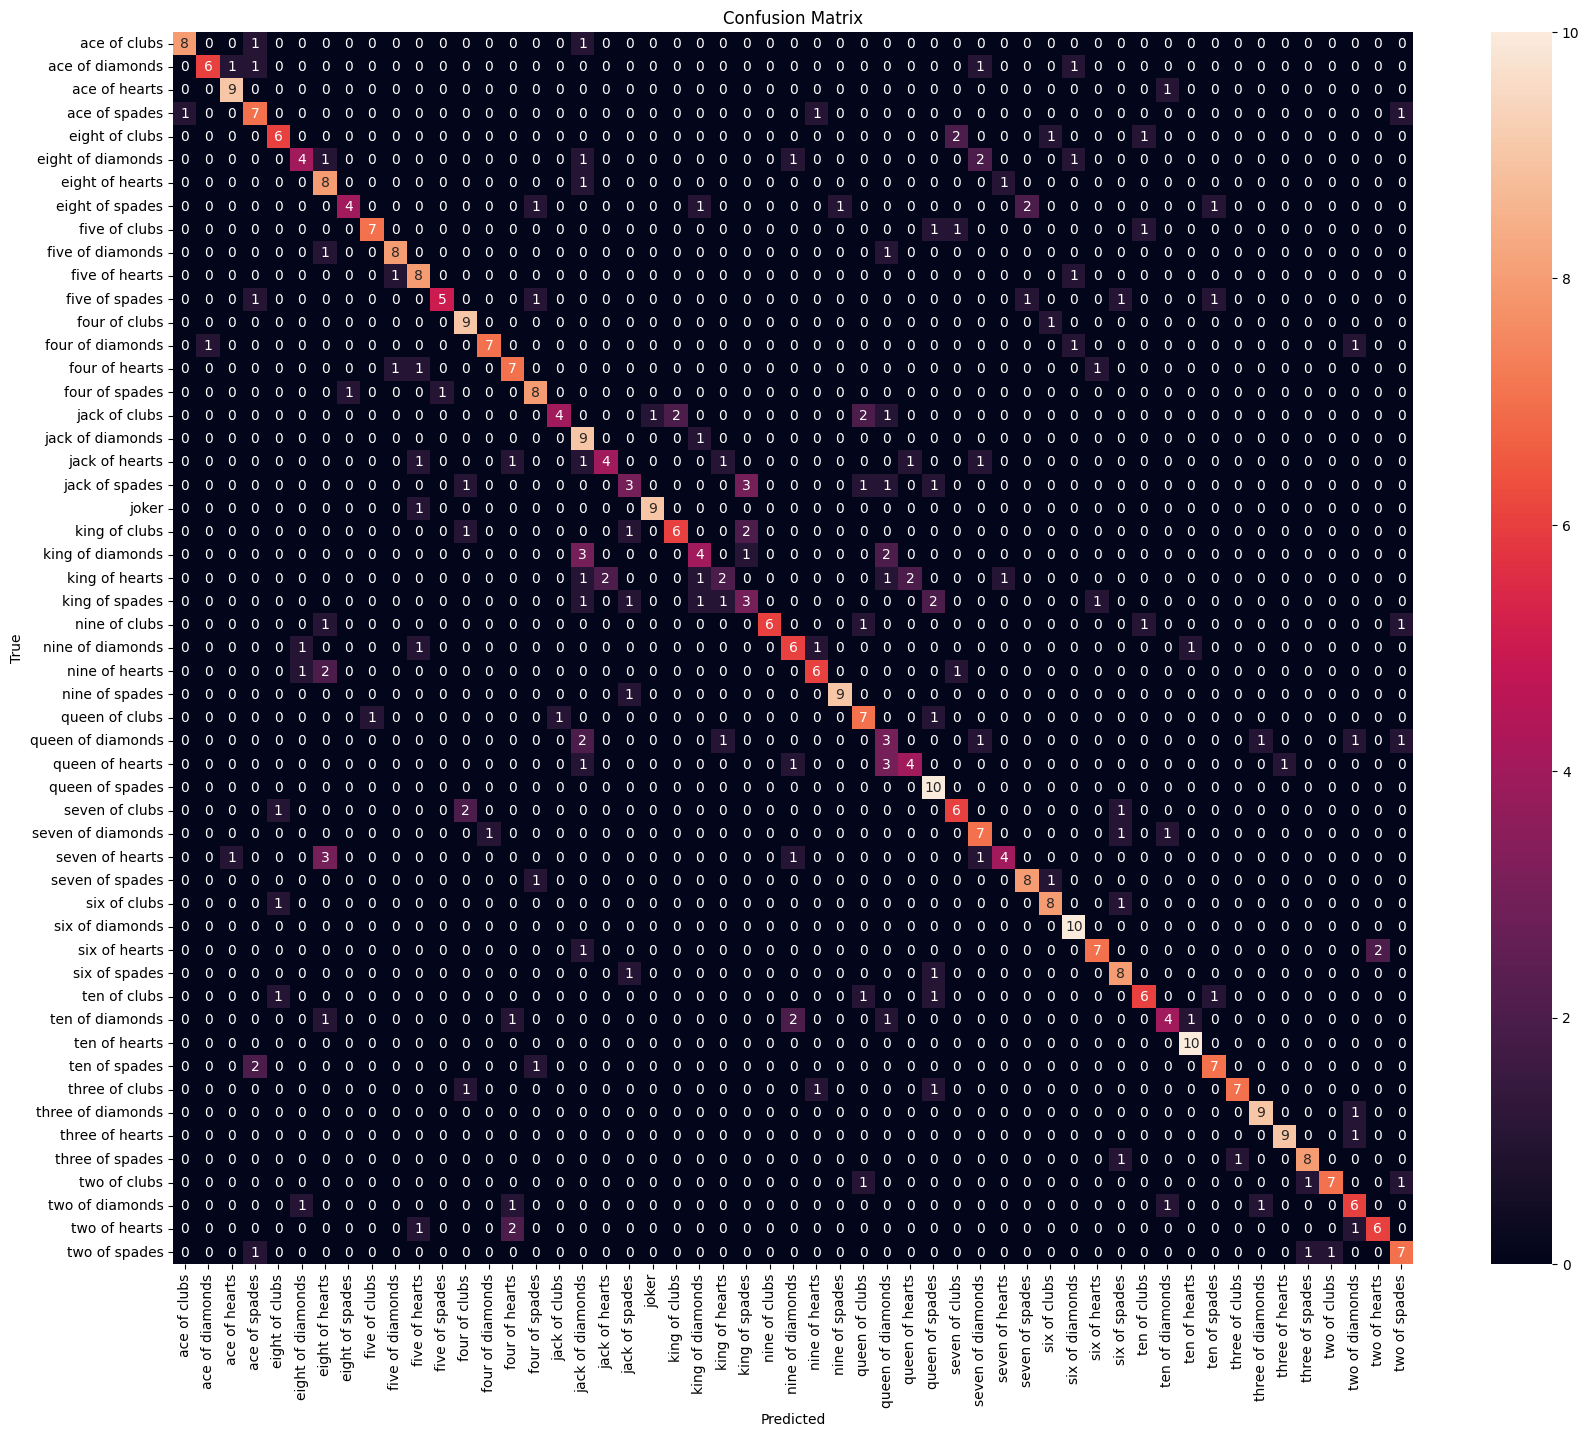

In [ ]:
# Ewaluacja modelu
test_loss, test_accuracy = model.evaluate(val_evaluate_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predykcja
y_true = np.concatenate([y for x, y in val_evaluate_ds], axis=0)  # Prawdziwe etykiety
y_pred = model.predict(val_evaluate_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # Przypisanie klas


# class_names = test_ds.class_names
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Macierz konfuzji
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Optymalny

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8193 - loss: 0.7188
Test Loss: 0.6760809421539307
Test Accuracy: 0.8264151215553284
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
                   precision    recall  f1-score   support

     ace of clubs       1.00      0.80      0.89        10
  ace of diamonds       0.80      0.80      0.80        10
    ace of hearts       0.91      1.00      0.95        10
    ace of spades       0.75      0.90      0.82        10
   eight of clubs       0.78      0.70      0.74        10
eight of diamonds       1.00      0.70      0.82        10
  eight of hearts       0.82      0.90      0.86        10
  eight of spades       0.82      0.90      0.86        10
    five of clubs       0.89      0.80      0.84        10
 five of diamonds       1.00      0.90      0.95        10
   five of hearts       0.82      0.90      0.86        10
   five of spades       0.70      0.70      0.70        10
    four of clubs       0.88      0.70      0.78      

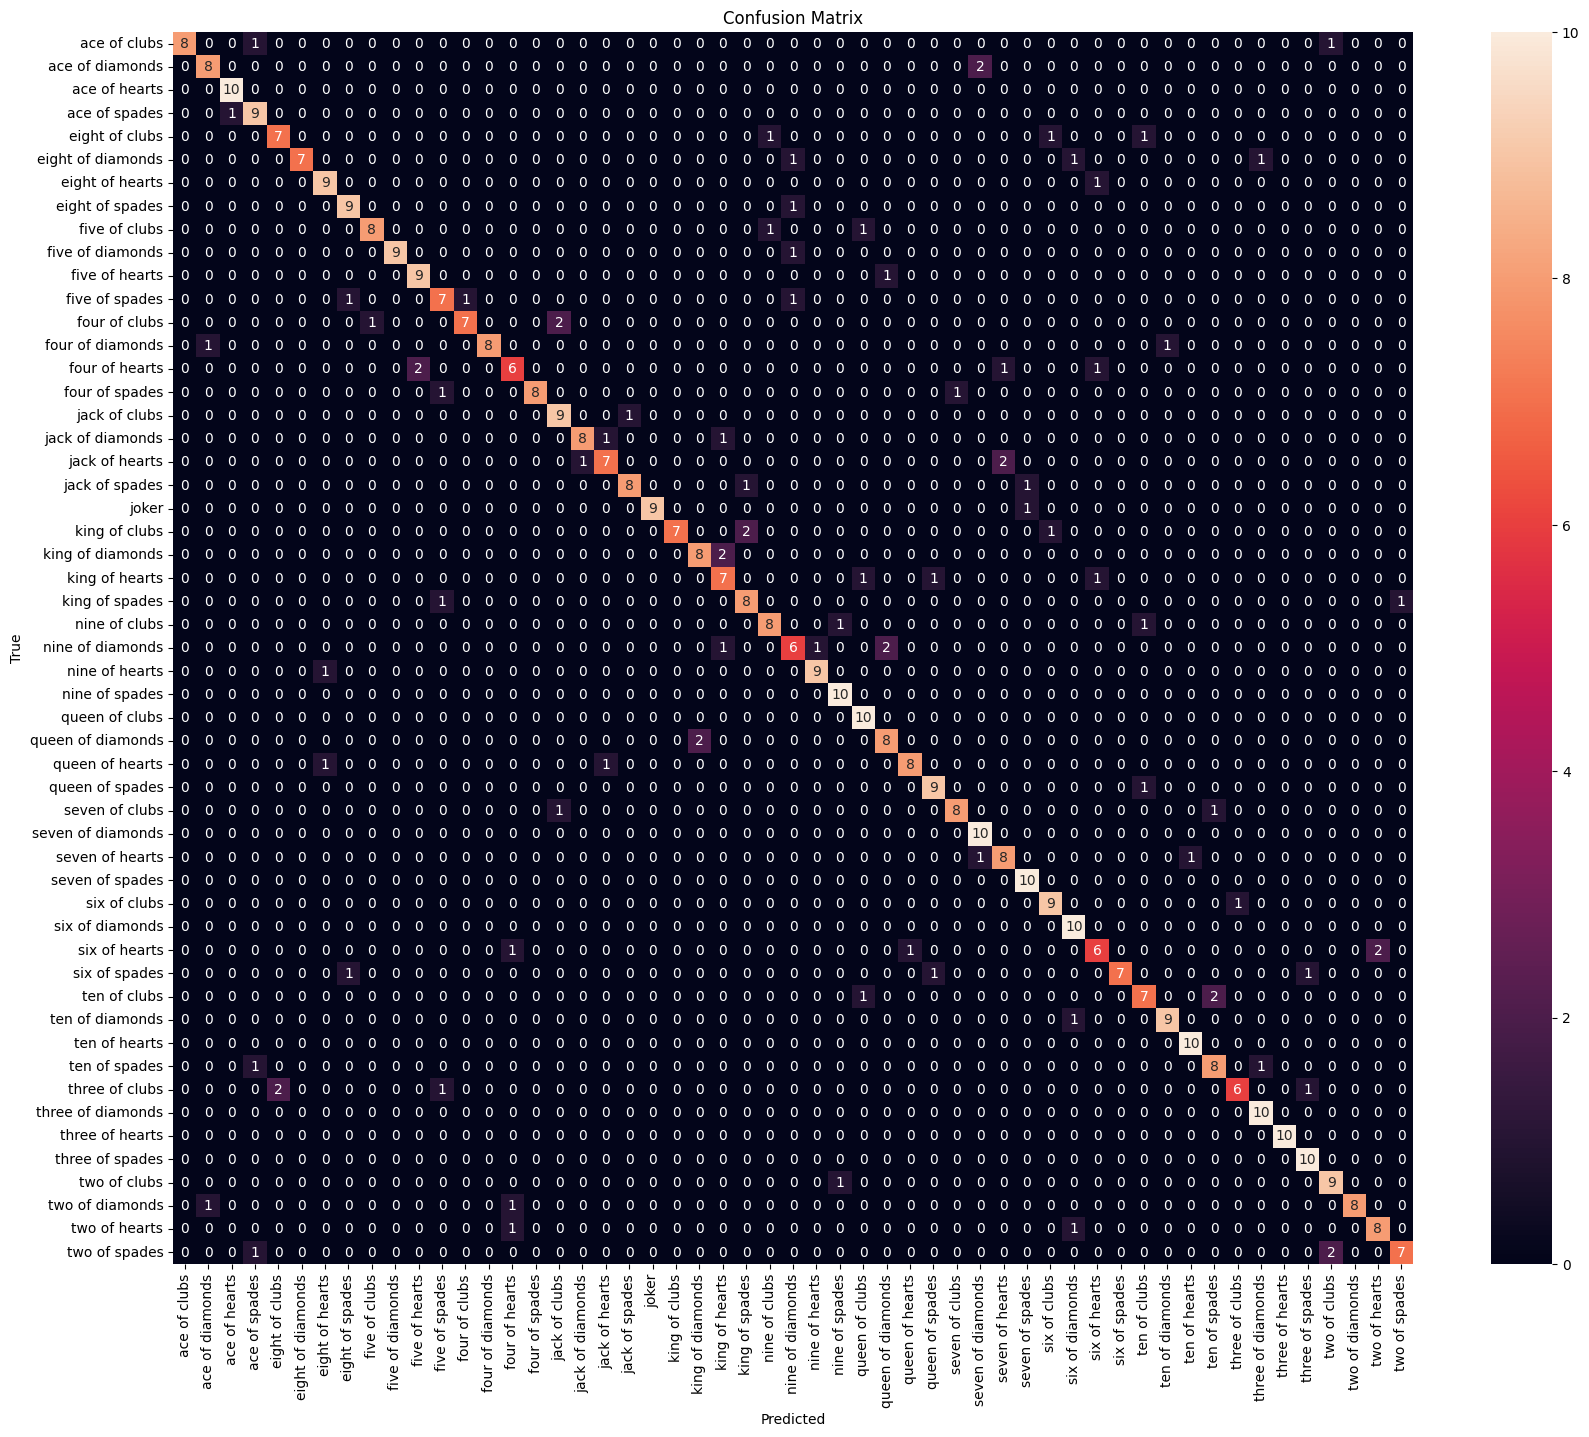

In [ ]:
# Ewaluacja modelu
test_loss, test_accuracy = model.evaluate(val_evaluate_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predykcja
y_true = np.concatenate([y for x, y in val_evaluate_ds], axis=0)  # Prawdziwe etykiety
y_pred = model.predict(val_evaluate_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # Przypisanie klas


# class_names = test_ds.class_names
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Macierz konfuzji
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Optymalny+

In [ ]:
# Ewaluacja modelu
test_loss, test_accuracy = model.evaluate(val_evaluate_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predykcja
y_true = np.concatenate([y for x, y in val_evaluate_ds], axis=0)  # Prawdziwe etykiety
y_pred = model.predict(val_evaluate_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # Przypisanie klas


# class_names = test_ds.class_names
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Macierz konfuzji
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## wykresy acc i val_los

In [ ]:
def charts(model_name):
  gdrive_path = '/content/drive/MyDrive'
  gdrive_path_work = f'{gdrive_path}/Cards'
  history_path = f'{gdrive_path_work}/history/{model_name}'

  with open(history_path, 'rb') as file:
      history = pickle.load(file)

  fig, ax = plt.subplots(1, 2, figsize=(10, 4))

  # Wykres strat
  ax[0].plot(history['loss'], label='Strata trenowania')
  ax[0].plot(history['val_loss'], label='Strata walidacji')
  ax[0].set_xlabel('Epoki')
  ax[0].set_ylabel('Strata')
  ax[0].legend()
  ax[0].set_title("Strata trenowania i walidacji")

  # Wykres dokładności
  ax[1].plot(history['accuracy'], label='Dokładność trenowania')
  ax[1].plot(history['val_accuracy'], label='Dokładność walidacji')
  ax[1].set_xlabel('Epoki')
  ax[1].set_ylabel('Dokładność')
  ax[1].legend()
  ax[1].set_title("Dokładność trenowania i walidacji")

  # Dostosowanie układu i wyświetlenie wykresu
  plt.tight_layout()
  plt.show()

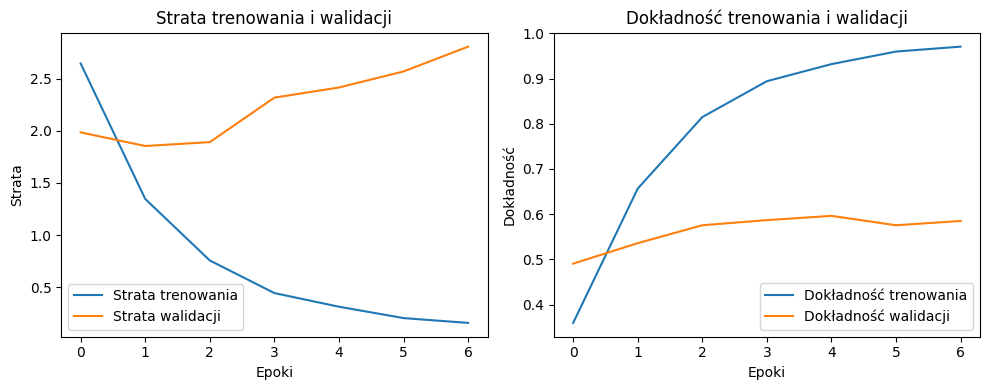

In [ ]:
charts('Bazowy')

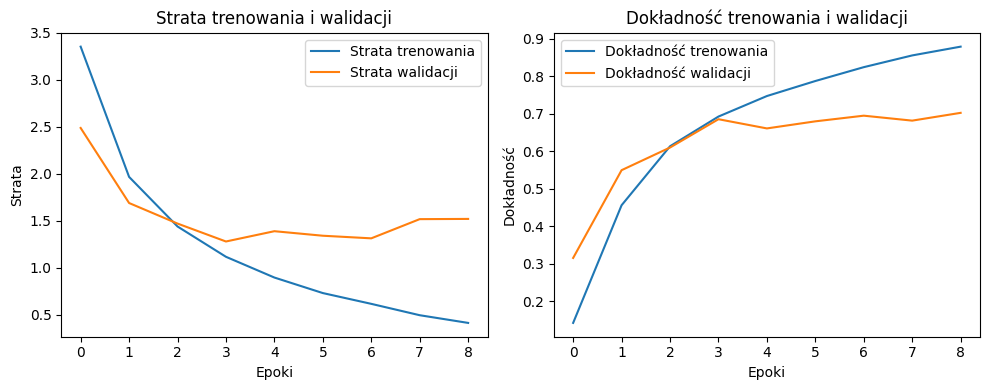

In [ ]:
charts('Pośredni')

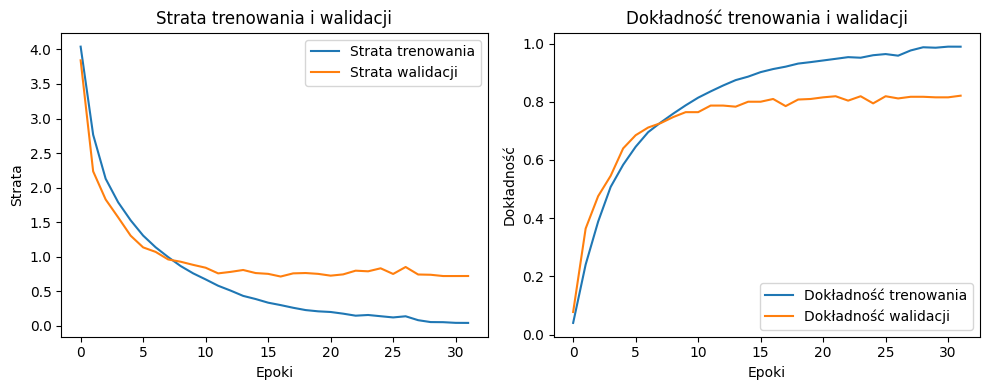

In [ ]:
charts('Optymalny')

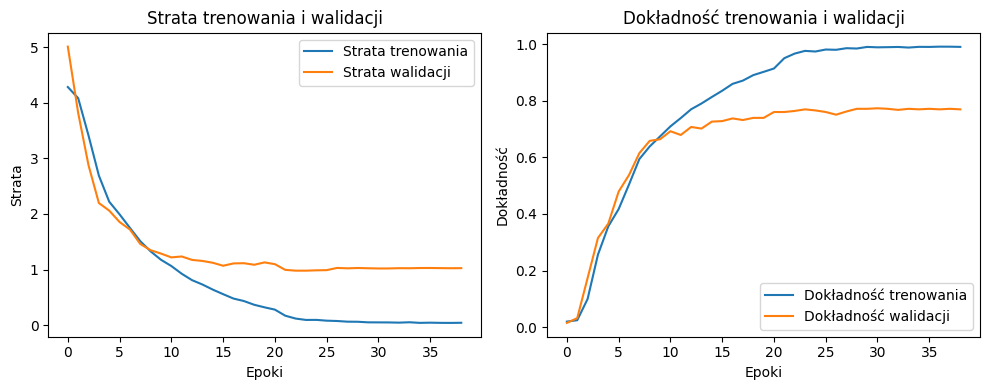

In [ ]:
charts('Optymalny+')

## Import

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Config

In [ ]:
gdrive_path = '/content/drive/MyDrive'

# Directory with the learned model
model_name = 'Optymalny.keras'
model_dir = f'{gdrive_path}/Cards/{model_name}'

# Image filename (with extension - e.g. myface.jpg)
# Image must be square
image_filename = 'as_serce.jpg'

# Class names
class_names_path = f'{gdrive_path}/Cards/class_names.json'
with open(class_names_path, 'r') as file:
  class_names = file.read()
  class_names = eval(class_names)

## Load model

In [ ]:
model_path = f'{model_dir}'
model = load_model(model_path)

## Evaluate

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8882 - loss: 0.3662
Test Loss: 0.31311729550361633
Test Accuracy: 0.8943396210670471
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
                   precision    recall  f1-score   support

     ace of clubs       0.75      0.60      0.67         5
  ace of diamonds       0.80      0.80      0.80         5
    ace of hearts       0.80      0.80      0.80         5
    ace of spades       0.83      1.00      0.91         5
   eight of clubs       0.83      1.00      0.91         5
eight of diamonds       0.83      1.00      0.91         5
  eight of hearts       1.00      1.00      1.00         5
  eight of spades       1.00      1.00      1.00         5
    five of clubs       1.00      1.00      1.00         5
 five of diamonds       1.00      1.00      1.00         5
   five of hearts       1.00      0.80      0.89         5
   five of spades       0.83      1.00      0.91         5
    four of clubs       1.00      0.60      0.75         

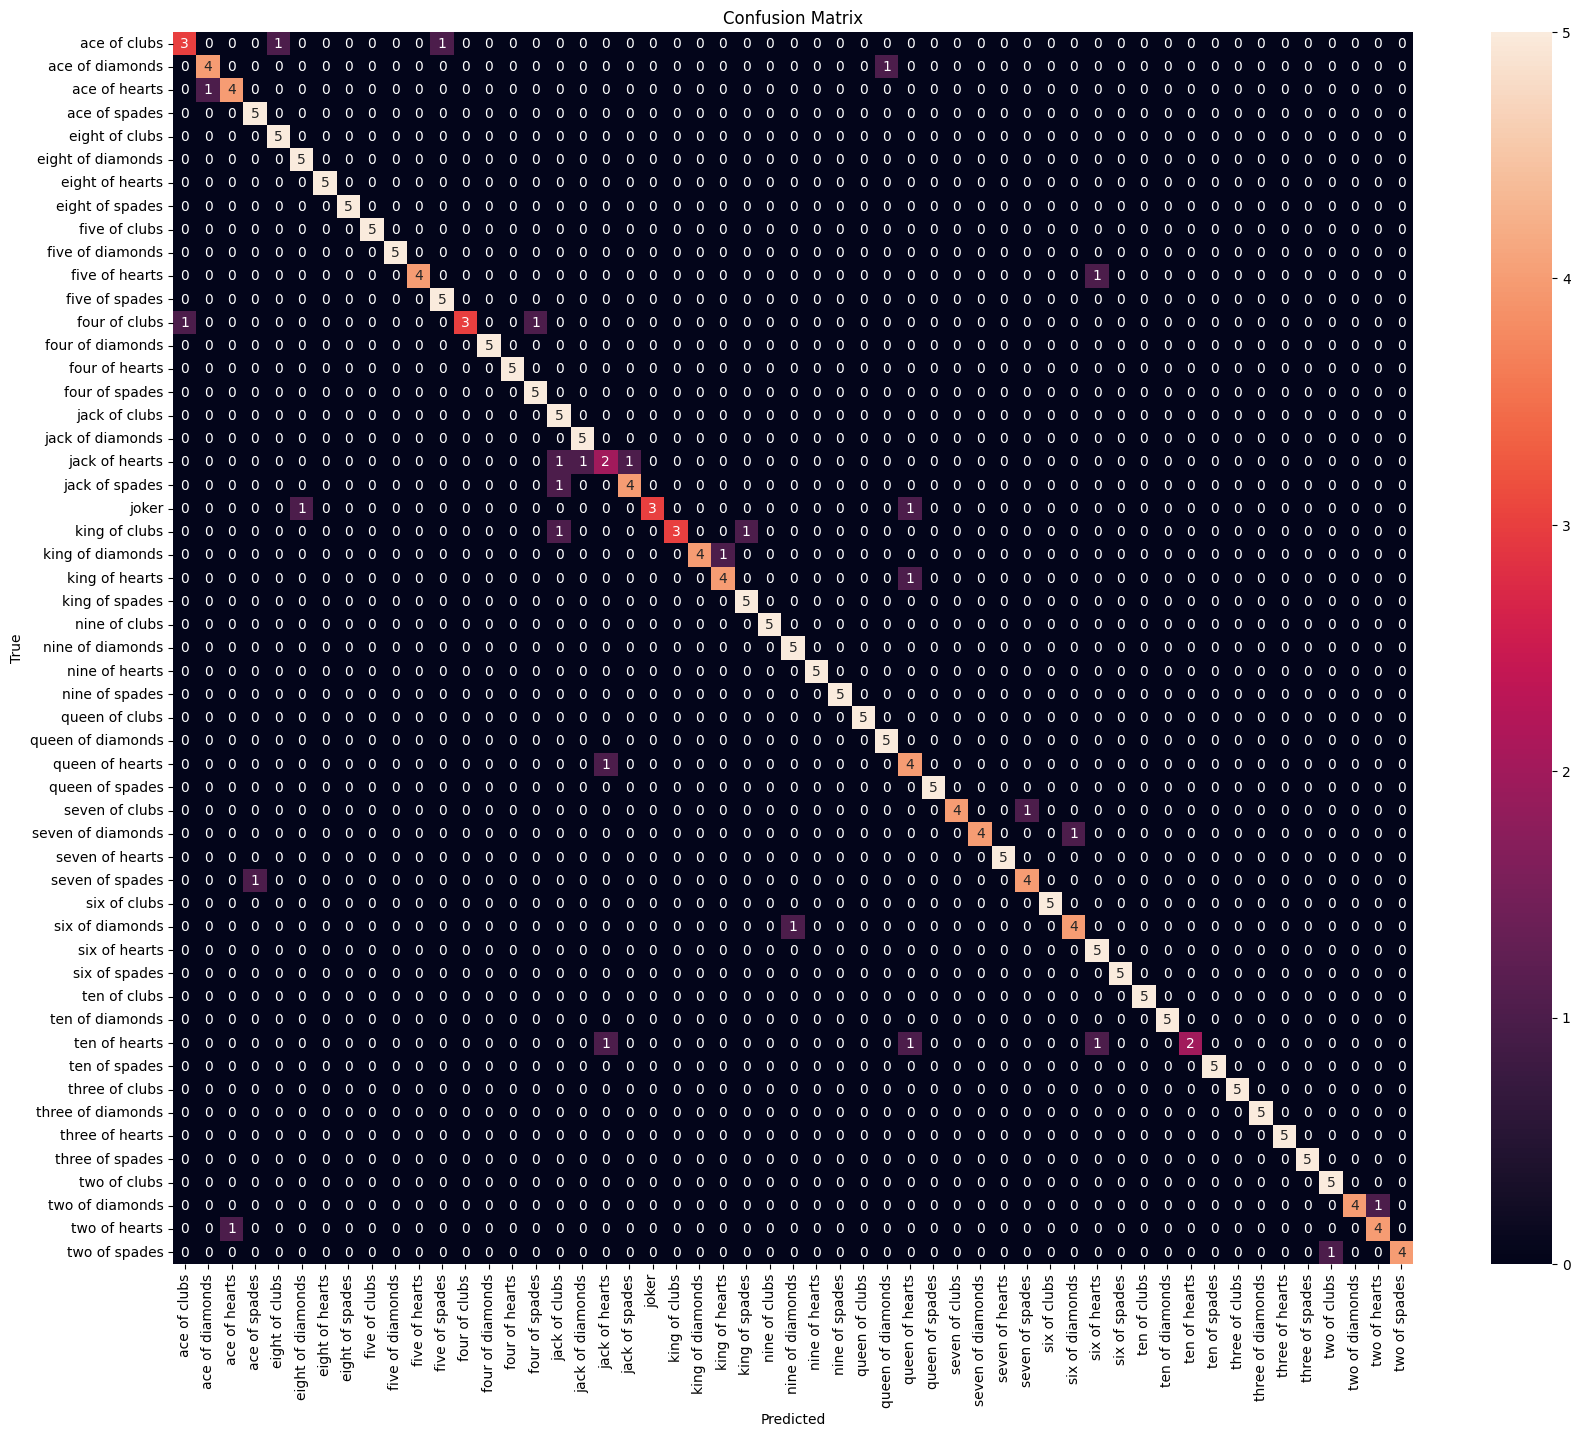

In [ ]:
# Ewaluacja modelu
test_loss, test_accuracy = model.evaluate(val_evaluate_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


y_true = np.concatenate([y for x, y in val_evaluate_ds], axis=0)  # Prawdziwe etykiety
y_pred = model.predict(val_evaluate_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # Przypisanie klas


# class_names = test_ds.class_names
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Macierz konfuzji
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Rozpoznanie kart

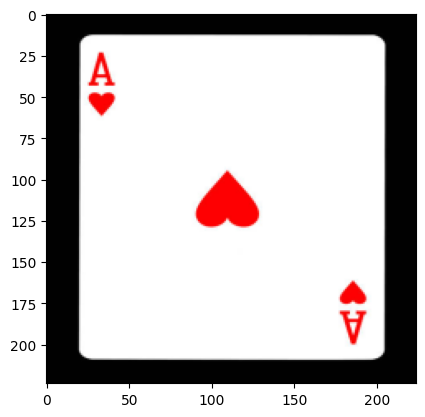

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
                   Prediction  In %
ace of hearts        0.210318  21.0
four of spades       0.141025  14.1
four of clubs        0.106215  10.6
ten of diamonds      0.093023   9.3
two of hearts        0.058674   5.9
four of hearts       0.042337   4.2
king of spades       0.041617   4.2
ace of spades        0.039988   4.0
two of diamonds      0.036283   3.6
nine of diamonds     0.029797   3.0
four of diamonds     0.024819   2.5
queen of spades      0.018896   1.9
five of spades       0.017962   1.8
six of diamonds      0.013450   1.3
nine of hearts       0.012031   1.2
ten of hearts        0.010699   1.1
ace of diamonds      0.008698   0.9
queen of hearts      0.007627   0.8
three of diamonds    0.007616   0.8
queen of diamonds    0.006447   0.6
queen of clubs       0.006271   0.6
jack of spades       0.005458   0.5
eight of hearts      0.005146   0.5
two of spades        0.004609   0.5
two of clubs         0.004472   0.4
king of hearts       0.00

In [ ]:
# Converting an image
img_path = f'{image_filename}'
img = cv.imread(img_path)
img = cv.resize(img, (224, 224), interpolation = cv.INTER_AREA)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Show image
plt.imshow(img)
plt.show()

# Prediction
img = img.reshape(1, 224, 224, 3) / 255.0
prediction = model.predict(img)

prediction_df = pd.DataFrame({
    "Prediction" :  prediction[0],
    "In %" : np.around(prediction[0]*100, 1).astype(str)
}, index = class_names)

print(prediction_df.sort_values(by = ["Prediction"], ascending=False))

## Wyświetlenie kilku obrazów z wyniikami predykcji

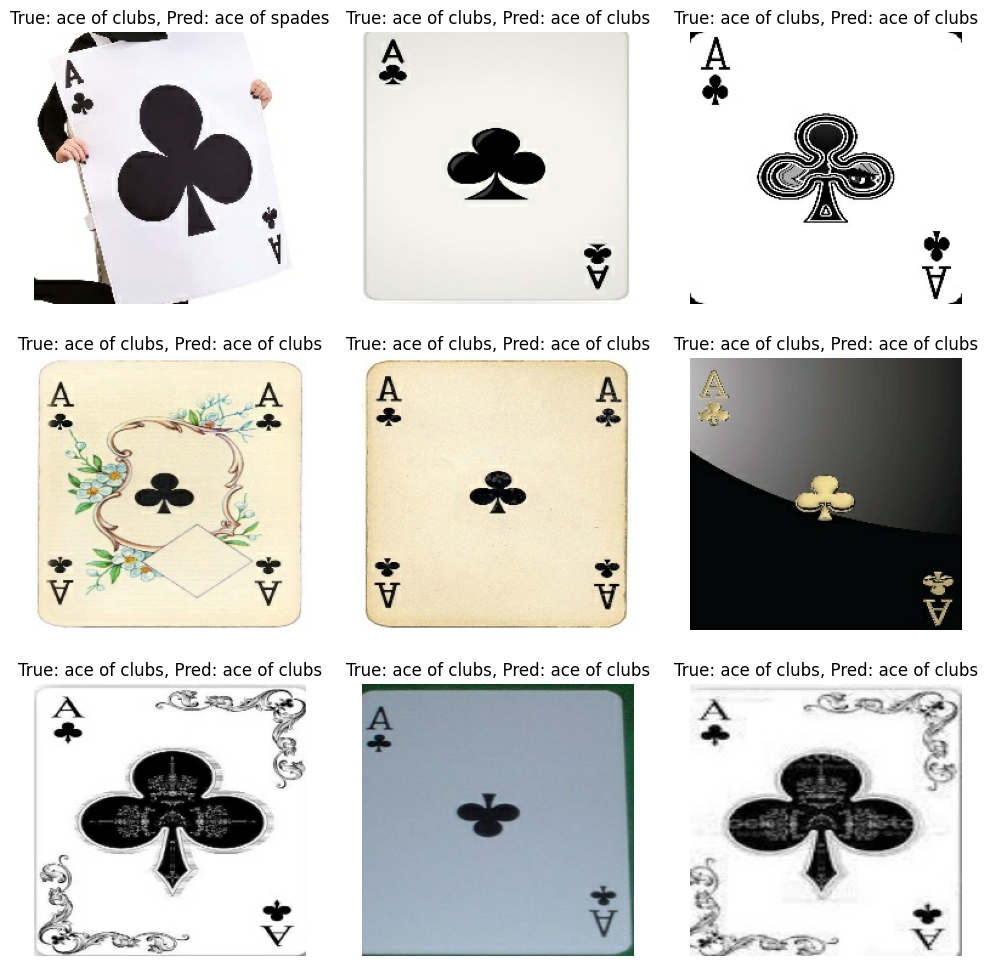

In [ ]:
import matplotlib.pyplot as plt

for images, labels in val_evaluate_ds.take(1):
    plt.figure(figsize=(12, 12))
    for i in range(9):  # Wyświetlenie 9 obrazów
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i].numpy()]
        predicted_label = class_names[y_pred_classes[i]]
        plt.title(f"True: {true_label}, Pred: {predicted_label}")
        plt.axis("off")
    plt.show()